In [54]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.signal import decimate
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, LocalOutlierFactor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import time
import shap

# Data Acquision (S2 to S11)

In [1]:

# --- Configuration ---
pkl_dir = "/kaggle/input/dataset-2"
output_csv = "combined_chest_data.csv"

# --- Load and combine data ---
all_subjects = []

# Make sure only S2 to S10 are included
subject_ids = [f"S{i}.pkl" for i in range(2, 12)]  # S2.pkl to S10.pkl
pkl_files = sorted([f for f in os.listdir(pkl_dir) if f in subject_ids])

for file in tqdm(pkl_files, desc="Processing S2 to S11 files"):
    file_path = os.path.join(pkl_dir, file)
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

        # Extract RespiBAN (chest) data
        chest = data['signal']['chest']
        subject = data['subject']
        labels = data['label']

        # Filter labels 0–4 only
        valid_mask = ~np.isin(labels, [5, 6, 7])

        # Convert to DataFrame
        df = pd.DataFrame({
            'ACC_x': chest['ACC'][valid_mask, 0],
            'ACC_y': chest['ACC'][valid_mask, 1],
            'ACC_z': chest['ACC'][valid_mask, 2],
            'ECG': chest['ECG'][valid_mask].flatten(),
            'EMG': chest['EMG'][valid_mask].flatten(),
            'EDA': chest['EDA'][valid_mask].flatten(),
            'Temp': chest['Temp'][valid_mask].flatten(),
            'Resp': chest['Resp'][valid_mask].flatten(),
            'subject': [subject] * np.sum(valid_mask),
            'label': labels[valid_mask]
        })

        all_subjects.append(df)

# --- Combine into one DataFrame ---
combined_chest_df = pd.concat(all_subjects, ignore_index=True)

Processing S2 to S11 files: 100%|██████████| 10/10 [01:36<00:00,  9.65s/it]


In [2]:
combined_chest_df.columns

Index(['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp',
       'subject', 'label'],
      dtype='object')

# Max. Frequency content 

In [3]:

def find_max_frequency(signal, fs, threshold=0.01):
    n = len(signal)
    if n == 0:
        return 0
    fft_vals = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(n, 1/fs)
    
    magnitude = np.abs(fft_vals)
    magnitude_norm = magnitude / np.max(magnitude)
    
    significant_freqs = fft_freqs[magnitude_norm > threshold]
    
    if len(significant_freqs) == 0:
        return 0
    else:
        return significant_freqs.max()

# Sampling frequency (update if different)
fs = 700

sensor_columns = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']

max_freqs_per_subject = {}

for subject_id, df_subj in combined_chest_df.groupby('subject'):
    max_freqs = {}
    for sensor in sensor_columns:
        signal = df_subj[sensor].dropna().values
        max_freq = find_max_frequency(signal, fs)
        max_freqs[sensor] = max_freq
    max_freqs_per_subject[subject_id] = max_freqs

# Print max frequencies per subject
for subject_id, freqs in max_freqs_per_subject.items():
    print(f"\nSubject: {subject_id}")
    for sensor, freq in freqs.items():
        print(f"  {sensor}: {freq:.4f} Hz")



Subject: S10
  ACC_x: 0.0037 Hz
  ACC_y: 1.8357 Hz
  ACC_z: 0.0354 Hz
  ECG: 99.8360 Hz
  EMG: 65.8188 Hz
  EDA: 0.0030 Hz
  Temp: 0.0000 Hz
  Resp: 1.6590 Hz

Subject: S11
  ACC_x: 0.0000 Hz
  ACC_y: 4.8937 Hz
  ACC_z: 0.0925 Hz
  ECG: 124.6652 Hz
  EMG: 79.8317 Hz
  EDA: 0.0008 Hz
  Temp: 0.0000 Hz
  Resp: 1.2183 Hz

Subject: S2
  ACC_x: 0.0061 Hz
  ACC_y: 0.0331 Hz
  ACC_z: 0.0356 Hz
  ECG: 100.0462 Hz
  EMG: 88.5884 Hz
  EDA: 0.0131 Hz
  Temp: 0.0005 Hz
  Resp: 1.7390 Hz

Subject: S3
  ACC_x: 0.0033 Hz
  ACC_y: 5.6456 Hz
  ACC_z: 0.4227 Hz
  ECG: 99.5046 Hz
  EMG: 186.5409 Hz
  EDA: 0.0049 Hz
  Temp: 0.0002 Hz
  Resp: 1.6669 Hz

Subject: S4
  ACC_x: 0.0021 Hz
  ACC_y: 0.0645 Hz
  ACC_z: 0.0633 Hz
  ECG: 132.3899 Hz
  EMG: 115.9122 Hz
  EDA: 0.0030 Hz
  Temp: 0.0000 Hz
  Resp: 1.7570 Hz

Subject: S5
  ACC_x: 0.0005 Hz
  ACC_y: 0.5216 Hz
  ACC_z: 0.1212 Hz
  ECG: 94.5379 Hz
  EMG: 83.6400 Hz
  EDA: 0.0043 Hz
  Temp: 0.0000 Hz
  Resp: 1.6395 Hz

Subject: S6
  ACC_x: 0.0058 Hz
  ACC_y

# Downsampling at 400 Hz

In [4]:

# --- Setup ---
fs = 700  # original sampling rate in Hz
target_fs = 400  # desired fixed downsample rate
downsample_factor = int(fs // target_fs)

sensor_columns = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
downsampled_subject_dfs = []

for subject_id, df_subj in combined_chest_df.groupby('subject'):
    downsampled_sensors = {}
    max_len = None

    for sensor in sensor_columns:
        signal = df_subj[sensor].dropna().values
        
        if downsample_factor > 1:
            downsampled_signal = decimate(signal, downsample_factor, ftype='fir', zero_phase=True)
        else:
            downsampled_signal = signal
        
        downsampled_sensors[sensor] = downsampled_signal

        if max_len is None:
            max_len = len(downsampled_signal)
        else:
            max_len = min(max_len, len(downsampled_signal))

    # --- Downsample Labels ---
    labels = df_subj['label'].values
    downsampled_labels = labels[::downsample_factor][:max_len]

    # --- Align all signals to min length ---
    for sensor in sensor_columns:
        downsampled_sensors[sensor] = downsampled_sensors[sensor][:max_len]

    df_downsampled_subj = pd.DataFrame(downsampled_sensors)
    df_downsampled_subj['subject'] = subject_id
    df_downsampled_subj['label'] = downsampled_labels
    df_downsampled_subj['time'] = np.arange(max_len) / target_fs

    downsampled_subject_dfs.append(df_downsampled_subj)

# --- Combine all ---
df1 = pd.concat(downsampled_subject_dfs, ignore_index=True)

df1.head(10)

,ACC_x,ACC_y,ACC_z,ECG,EMG,EDA,Temp,Resp,subject,label,time
0,1.1278,0.1520,0.3416,-1.333694,-0.013687,0.716019,33.695862,0.213623,S10,0,0.0000
1,1.0932,0.1888,0.2922,-1.327744,-0.021927,0.714493,33.741333,0.192261,S10,0,0.0025
2,1.0354,0.2094,0.1858,-1.322067,-0.009018,0.715637,33.717072,0.205994,S10,0,0.0050
3,0.9666,0.2118,0.0412,-1.316345,-0.002380,0.714874,33.741333,0.193787,S10,0,0.0075
4,0.8916,0.2040,-0.1228,-1.310257,0.001053,0.715256,33.747406,0.172424,S10,0,0.0100
5,0.8358,0.1978,-0.3018,-1.304306,-0.008972,0.713730,33.744385,0.181580,S10,0,0.0125
6,0.8042,0.1906,-0.4724,-1.298950,-0.037399,0.712967,33.753479,0.196838,S10,0,0.0150
7,0.7880,0.1834,-0.6210,-1.292908,-0.045181,0.713730,33.717072,0.157166,S10,0,0.0175
8,0.7880,0.1742,-0.7352,-1.287277,-0.045135,0.711441,33.730713,0.138855,S10,0,0.0200
9,0.7968,0.1642,-0.8110,-1.281830,-0.046829,0.712585,33.729218,0.160217,S10,0,0.0225


In [5]:
df1['label'].value_counts()

label
0    19235296
1     8200501
4     5530002
2     4581500
3     2596300
Name: count, dtype: int64

In [6]:
df1=df1.drop(columns=['subject','time'])

# feature extraction

In [7]:
def extract_features(df_window, sensor_columns):
    """
    Extract features from a window of sensor data with comprehensive error handling
    """
    features = {}
    epsilon = 1e-10  # Small positive constant to prevent division by zero
    
    # Helper function to get sensor data
    def get_sensor_data(sensor_prefix):
        return [col for col in sensor_columns if col.startswith(sensor_prefix)]
    
    # Helper function to safely calculate sampling frequency
    def get_sampling_frequency():
        try:
            time_diff = (df_window.index[1] - df_window.index[0]).total_seconds()
            return 1/max(time_diff, epsilon)
        except:
            return 1/epsilon  # Fallback value
    
    # ACC features (4 features)
    acc_cols = get_sensor_data('ACC')
    if acc_cols:
        for axis in ['x', 'y', 'z']:
            axis_col = next((col for col in acc_cols if axis in col.lower()), None)
            if axis_col and len(df_window[axis_col]) > 1:  # Need at least 2 samples
                acc_data = df_window[axis_col].dropna()
                if len(acc_data) < 2:
                    continue
                    
                features[f'ACC_{axis}_mean'] = acc_data.mean()
                features[f'ACC_{axis}_std'] = acc_data.std()
                features[f'ACC_{axis}_abs_integral'] = np.trapz(np.abs(acc_data))
                
                try:
                    fs = get_sampling_frequency()
                    f, Pxx = signal.welch(acc_data, fs=fs)
                    features[f'ACC_{axis}_peak_freq'] = f[np.argmax(Pxx)] if len(Pxx) > 0 else 0
                except:
                    features[f'ACC_{axis}_peak_freq'] = 0
    
    # ECG features (17 features)
    ecg_cols = get_sensor_data('ECG')
    if ecg_cols and len(df_window[ecg_cols[0]]) > 1:
        ecg_data = df_window[ecg_cols[0]].dropna()
        if len(ecg_data) > 1:
            # Time-domain HRV features
            rr_intervals = np.diff(ecg_data.index).astype('timedelta64[s]').astype(float)
            valid_rr = rr_intervals > 0
            
            features['ECG_HR_mean'] = 60/np.mean(rr_intervals[valid_rr]) if np.any(valid_rr) else 0
            features['ECG_SDNN'] = np.std(rr_intervals[valid_rr]) if np.any(valid_rr) else 0
            
            if len(rr_intervals) > 1:
                diff_rr = np.diff(rr_intervals)
                features['ECG_RMSSD'] = np.sqrt(np.mean(np.square(diff_rr)))
                nn50 = np.sum(np.abs(diff_rr) > 0.05)
                features['ECG_NN50'] = nn50
                features['ECG_pNN50'] = nn50/len(diff_rr) if len(diff_rr) > 0 else 0
                features['ECG_TINN'] = np.percentile(rr_intervals, 75) - np.percentile(rr_intervals, 25)
            else:
                for f in ['ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50', 'ECG_TINN']:
                    features[f] = 0
            
            # Frequency-domain HRV features
            try:
                fs = get_sampling_frequency()
                f, Pxx = signal.welch(ecg_data, fs=fs)
                
                vlf_band = (0.003, 0.04)
                lf_band = (0.04, 0.15)
                hf_band = (0.15, 0.4)
                
                vlf_power = np.trapz(Pxx[(f >= vlf_band[0]) & (f < vlf_band[1])])
                lf_power = np.trapz(Pxx[(f >= lf_band[0]) & (f < lf_band[1])])
                hf_power = np.trapz(Pxx[(f >= hf_band[0]) & (f < hf_band[1])])
                total_power = vlf_power + lf_power + hf_power + epsilon
                
                features.update({
                    'ECG_VLF_energy': vlf_power,
                    'ECG_LF_energy': lf_power,
                    'ECG_HF_energy': hf_power,
                    'ECG_LF_HF_ratio': lf_power/(hf_power + epsilon),
                    'ECG_LF_norm': lf_power/total_power,
                    'ECG_HF_norm': hf_power/total_power,
                    'ECG_relative_power': (lf_power + hf_power)/total_power
                })
            except:
                for f in ['ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
                         'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power']:
                    features[f] = 0
            
            # Nonlinear features
            if len(rr_intervals) > 1:
                try:
                    diff_rr = np.diff(rr_intervals)
                    sd1 = np.std(diff_rr)/np.sqrt(2)
                    sd2 = np.std(rr_intervals[:-1] + rr_intervals[1:])/np.sqrt(2)
                    hist, _ = np.histogram(rr_intervals, bins='auto')
                    features.update({
                        'ECG_SD1': sd1,
                        'ECG_SD2': sd2,
                        'ECG_entropy': entropy(hist) if np.any(hist) else 0
                    })
                except:
                    for f in ['ECG_SD1', 'ECG_SD2', 'ECG_entropy']:
                        features[f] = 0

    # EDA features (12 features)
    eda_cols = get_sensor_data('EDA')
    if eda_cols and len(df_window[eda_cols[0]]) > 1:
        eda_data = df_window[eda_cols[0]].dropna()
        if len(eda_data) > 1:
            features['EDA_mean'] = eda_data.mean()
            features['EDA_std'] = eda_data.std()
            
            try:
                peaks, _ = find_peaks(eda_data, height=0.05, distance=10)
                features['EDA_SCR_count'] = len(peaks)
                features['EDA_SCR_amplitude'] = np.mean(eda_data.iloc[peaks]) if len(peaks) > 0 else 0
                features['EDA_SCR_duration'] = len(eda_data)/max(len(peaks), 1)
                features['EDA_SCR_slope'] = np.mean(np.gradient(eda_data.iloc[peaks])) if len(peaks) > 0 else 0
                features['EDA_dynamic_range'] = eda_data.max() - eda_data.min()
            except:
                for f in ['EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration', 
                         'EDA_SCR_slope', 'EDA_dynamic_range']:
                    features[f] = 0

    # EMG features (14 features)
    emg_cols = get_sensor_data('EMG')
    if emg_cols and len(df_window[emg_cols[0]]) > 1:
        emg_data = df_window[emg_cols[0]].dropna()
        if len(emg_data) > 1:
            features['EMG_mean'] = emg_data.mean()
            features['EMG_std'] = emg_data.std()
            features['EMG_dynamic_range'] = emg_data.max() - emg_data.min()
            
            try:
                zero_crossings = np.where(np.diff(np.sign(emg_data - emg_data.mean())))[0]
                features['EMG_ZCR'] = len(zero_crossings)/len(emg_data)
                
                peaks, _ = find_peaks(emg_data, height=emg_data.mean() + emg_data.std())
                features.update({
                    'EMG_peaks': len(peaks),
                    'EMG_signal_energy': np.sum(emg_data**2),
                    'EMG_amplitude_mean': np.mean(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,
                    'EMG_amplitude_std': np.std(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,
                    'EMG_amplitude_max': np.max(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,
                    'EMG_amplitude_min': np.min(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,

                })
            except:
                for f in ['EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
                         'EMG_amplitude_mean', 'EMG_amplitude_std',
                         'EMG_amplitude_max', 'EMG_amplitude_min']:
                    features[f] = 0

    # RESP features (7 features)
    resp_cols = get_sensor_data('Resp')
    if resp_cols and len(df_window[resp_cols[0]]) > 1:
        resp_data = df_window[resp_cols[0]].dropna()
        if len(resp_data) > 1:
            try:
                peaks, _ = find_peaks(resp_data)
                valleys, _ = find_peaks(-resp_data)
                
                if len(peaks) > 1 and len(valleys) > 1:
                    inhale_durations = np.diff(valleys)
                    exhale_durations = np.diff(peaks)
                    time_unit = (df_window.index[1] - df_window.index[0]).total_seconds()
                    
                    features.update({
                        'Resp_inhale_mean': np.mean(inhale_durations),
                        'Resp_inhale_std': np.std(inhale_durations),
                        'Resp_exhale_mean': np.mean(exhale_durations),
                        'Resp_exhale_std': np.std(exhale_durations),
                        'Resp_duration_ratio': np.mean(inhale_durations)/max(np.mean(exhale_durations), epsilon),
                        'Resp_stretch': np.mean(resp_data[peaks]) - np.mean(resp_data[valleys]),
                        'Resp_rate': 60/(max(np.mean(np.diff(peaks)) * time_unit, epsilon))
                    })
                else:
                    for f in ['Resp_inhale_mean', 'Resp_inhale_std', 'Resp_exhale_mean',
                             'Resp_exhale_std', 'Resp_duration_ratio', 'Resp_stretch', 'Resp_rate']:
                        features[f] = 0
            except:
                for f in ['Resp_inhale_mean', 'Resp_inhale_std', 'Resp_exhale_mean',
                         'Resp_exhale_std', 'Resp_duration_ratio', 'RESP_stretch', 'RESP_rate']:
                    features[f] = 0

    # TEMP features (6 features)
    temp_cols = get_sensor_data('Temp')
    if temp_cols and len(df_window[temp_cols[0]]) > 1:
        temp_data = df_window[temp_cols[0]].dropna()
        if len(temp_data) > 1:
            features.update({
                'Temp_mean': temp_data.mean(),
                'Temp_std': temp_data.std(),
                'Temp_min': temp_data.min(),
                'Temp_max': temp_data.max(),
                'Temp_range': temp_data.max() - temp_data.min()
            })
            
            try:
                x = np.arange(len(temp_data))
                slope, _, _, _, _ = stats.linregress(x, temp_data)
                features['Temp_slope'] = slope
            except:
                features['Temp_slope'] = 0
    
    return features

# rolling windows

In [8]:
def process_rolling_windows(df, sampling_rate=400, window_size_sec=60, overlap=0.5, verbose=True):
    """
    Process dataframe using fixed sampling rate
    
    Args:
        df: Input DataFrame (must be time-indexed)
        sampling_rate: Samples per second (400Hz)
        window_size_sec: Window duration in seconds
        overlap: Fraction of window overlap (0-1)
        verbose: Whether to show progress
    """
    # Validate input
    if len(df) == 0:
        raise ValueError("Input dataframe is empty")
    
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index)
        except Exception as e:
            raise ValueError(f"Could not convert index to datetime: {str(e)}")
    
    # Calculate window parameters
    window_size_samples = int(window_size_sec * sampling_rate)
    step_size_samples = int(window_size_samples * (1 - overlap))
    total_samples = len(df)
    
    if window_size_samples > total_samples:
        raise ValueError(f"Window size ({window_size_samples} samples) exceeds data length ({total_samples} samples)")
    
    # Calculate total windows
    total_windows = ((total_samples - window_size_samples) // step_size_samples) + 1
    
    if verbose:
        print(f"Processing {total_windows} windows ({window_size_sec}s at {sampling_rate}Hz, {overlap*100}% overlap)")
    
    # Process each window
    results = []
    for i in range(total_windows):
        start_idx = i * step_size_samples
        end_idx = start_idx + window_size_samples
        window_df = df.iloc[start_idx:end_idx]
        
        if len(window_df) == window_size_samples:
            results.append(window_df)  # Just store the window for this simplified version
            
        if verbose and (i+1) % max(1, total_windows//10) == 0:  # Update every ~10%
            print(f"Processed {i+1}/{total_windows} windows ({(i+1)/total_windows*100:.1f}%)")
    
    if verbose:
        print(f"Completed {len(results)}/{total_windows} windows")
    
    return results

In [9]:
def extract_features_from_data(df1):
    """
    Extract features using sliding window of 30sec with 50% overlap on df1 and store in df2
    
    Args:
        df1: Input DataFrame with sensor data
        df2: Output DataFrame to store extracted features
    """
    # Get sensor columns (assuming all columns except potential non-sensor ones)
    sensor_columns = [col for col in df1.columns if col in ['ACC_x', 'ACC_y', 'ACC_z', 
                                                          'ECG', 'EDA', 'EMG', 'Resp', 'Temp']]
    
    # Process with 30-second windows and 50% overlap
    windows = process_rolling_windows(
        df=df1,
        window_size_sec=30,
        overlap=0.5,
        verbose=True
    )
    
    # Extract features for each window
    features_list = []
    for window_df in windows:
        features = extract_features(window_df, sensor_columns)
        features_list.append(features)
        # Assign mode label for current window
        label_mode = window_df['label'].mode()
        features['label'] = label_mode[0] if not label_mode.empty else np.nan
    
    # Convert to DataFrame and store in df2
    df2 = pd.DataFrame(features_list)
    
    return df2

In [10]:
# Assuming df1 contains your raw sensor data and df2 will store the features
df2 = extract_features_from_data(df1)

Processing 6689 windows (30s at 400Hz, 50.0% overlap)
Processed 668/6689 windows (10.0%)
Processed 1336/6689 windows (20.0%)
Processed 2004/6689 windows (30.0%)
Processed 2672/6689 windows (39.9%)
Processed 3340/6689 windows (49.9%)
Processed 4008/6689 windows (59.9%)
Processed 4676/6689 windows (69.9%)
Processed 5344/6689 windows (79.9%)
Processed 6012/6689 windows (89.9%)
Processed 6680/6689 windows (99.9%)
Completed 6689/6689 windows


In [11]:
df2.head()

,ACC_x_mean,ACC_x_std,ACC_x_abs_integral,ACC_x_peak_freq,ACC_y_mean,ACC_y_std,ACC_y_abs_integral,ACC_y_peak_freq,ACC_z_mean,ACC_z_std,...,Resp_duration_ratio,RESP_stretch,RESP_rate,Temp_mean,Temp_std,Temp_min,Temp_max,Temp_range,Temp_slope,label
0,0.876836,0.014338,10521.027609,0,0.021927,0.025458,283.828795,0,-0.272395,0.063769,...,0,0,0,33.745495,0.024995,33.659485,33.902283,0.242798,0,0
1,0.878254,0.004702,10538.172310,0,0.003419,0.008423,69.159378,0,-0.272993,0.018724,...,0,0,0,33.770809,0.029185,33.680695,33.925049,0.244354,0,0
2,0.883957,0.033430,10606.554203,0,0.017175,0.071681,560.840285,0,-0.236976,0.056655,...,0,0,0,33.794304,0.025404,33.706482,33.932678,0.226196,0,0
3,0.889101,0.050159,10668.318403,0,0.029089,0.096158,1018.535599,0,-0.207139,0.057198,...,0,0,0,33.794327,0.024747,33.714050,33.932678,0.218628,0,0
4,0.884423,0.043140,10612.122704,0,0.017364,0.080228,731.996706,0,-0.234572,0.054427,...,0,0,0,33.787811,0.023671,33.667084,33.928101,0.261017,0,0


# baseline + amusement (non-stress) and stress seperation

In [12]:
def map_stress_labels(df2):
    """
    Map original WESAD labels to binary stress (1) and non-stress (0) classes.

    Args:
        df2 (pd.DataFrame): DataFrame containing a 'label' column.

    Returns:
        pd.DataFrame: New DataFrame df3 with binary 'stress_label'.
    """
    df3 = df2.copy()

    # Mapping: 1 and 3 -> non-stress (0), 2 -> stress (1)
    label_map = {1: 0, 3: 0, 2: 1}
    df3['stress_label'] = df3['label'].map(label_map)

    # Optionally drop rows with NaN (i.e., labels not 1, 2, or 3)
    df3 = df3.dropna(subset=['stress_label']).reset_index(drop=True)

    return df3


In [13]:
df3 = map_stress_labels(df2)
df3= df3.drop(columns=["label"])

In [14]:
df3.columns

Index(['ACC_x_mean', 'ACC_x_std', 'ACC_x_abs_integral', 'ACC_x_peak_freq',
       'ACC_y_mean', 'ACC_y_std', 'ACC_y_abs_integral', 'ACC_y_peak_freq',
       'ACC_z_mean', 'ACC_z_std', 'ACC_z_abs_integral', 'ACC_z_peak_freq',
       'ECG_HR_mean', 'ECG_SDNN', 'ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50',
       'ECG_TINN', 'ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
       'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power',
       'ECG_SD1', 'ECG_SD2', 'ECG_entropy', 'EDA_mean', 'EDA_std',
       'EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration',
       'EDA_SCR_slope', 'EDA_dynamic_range', 'EMG_mean', 'EMG_std',
       'EMG_dynamic_range', 'EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
       'EMG_amplitude_mean', 'EMG_amplitude_std', 'EMG_amplitude_max',
       'EMG_amplitude_min', 'Resp_inhale_mean', 'Resp_inhale_std',
       'Resp_exhale_mean', 'Resp_exhale_std', 'Resp_duration_ratio',
       'RESP_stretch', 'RESP_rate', 'Temp_mean', 'Temp_std', 'Temp_min',
 

# Feature Selection based on mutual information

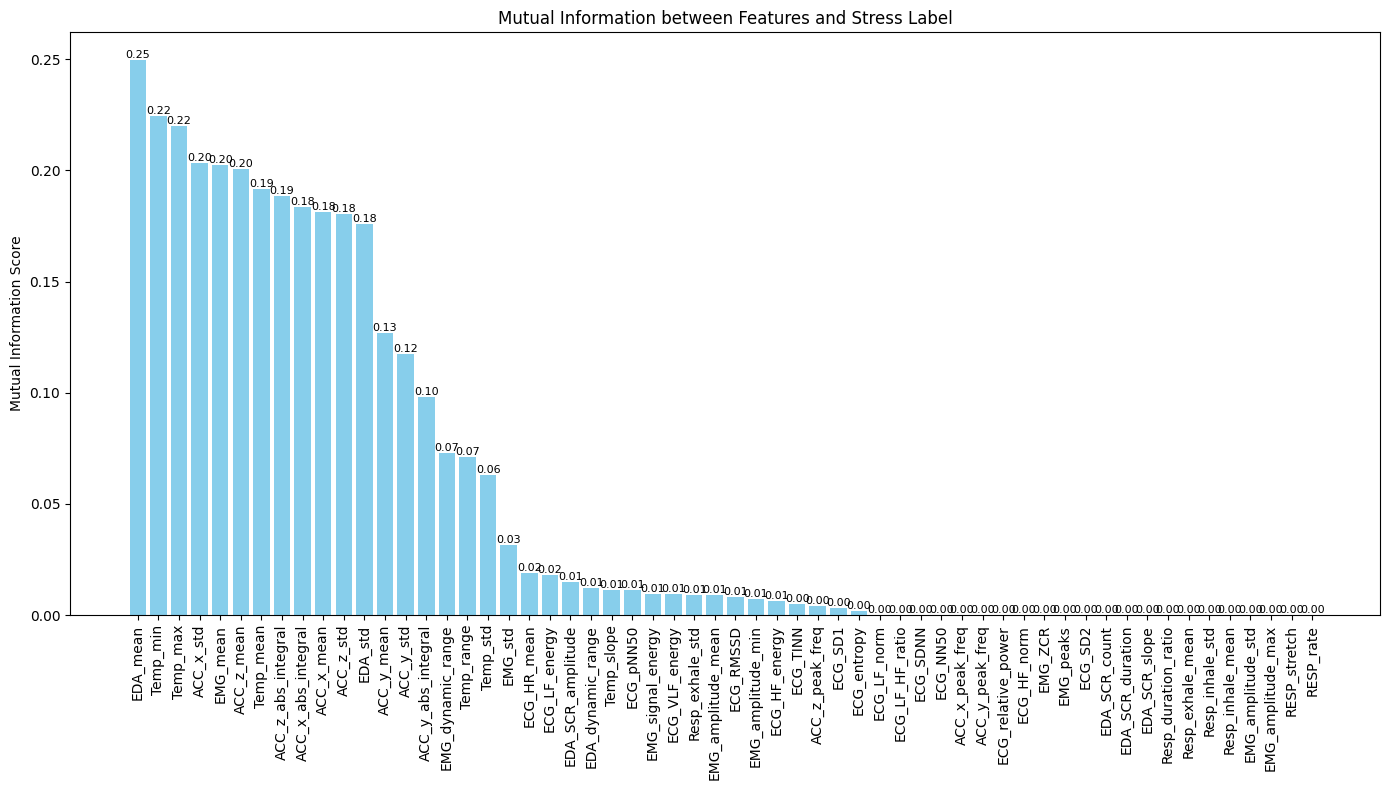

In [16]:

# Feature columns (excluding the target)
feature_columns = [
       'ACC_x_mean', 'ACC_x_std', 'ACC_x_abs_integral', 'ACC_x_peak_freq',
       'ACC_y_mean', 'ACC_y_std', 'ACC_y_abs_integral', 'ACC_y_peak_freq',
       'ACC_z_mean', 'ACC_z_std', 'ACC_z_abs_integral', 'ACC_z_peak_freq',
       'ECG_HR_mean', 'ECG_SDNN', 'ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50',
       'ECG_TINN', 'ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
       'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power',
       'ECG_SD1', 'ECG_SD2', 'ECG_entropy', 'EDA_mean', 'EDA_std',
       'EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration',
       'EDA_SCR_slope', 'EDA_dynamic_range', 'EMG_mean', 'EMG_std',
       'EMG_dynamic_range', 'EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
       'EMG_amplitude_mean', 'EMG_amplitude_std', 'EMG_amplitude_max',
       'EMG_amplitude_min', 'Resp_inhale_mean', 'Resp_inhale_std',
       'Resp_exhale_mean', 'Resp_exhale_std', 'Resp_duration_ratio',
       'RESP_stretch', 'RESP_rate', 'Temp_mean', 'Temp_std', 'Temp_min',
       'Temp_max', 'Temp_range', 'Temp_slope'
]

# Target
target_column = 'stress_label'

# Extract features and labels
X = df3[feature_columns]
y = df3[target_column]

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi_scores, index=feature_columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 8))
bars = plt.bar(mi_series.index, mi_series.values, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information between Features and Stress Label")

# Annotate each bar with its score
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [17]:
len(feature_columns)

58

In [18]:
mi_series

EDA_mean               0.249664
Temp_min               0.224506
Temp_max               0.219863
ACC_x_std              0.203394
EMG_mean               0.202587
ACC_z_mean             0.200649
Temp_mean              0.191823
ACC_z_abs_integral     0.188302
ACC_x_abs_integral     0.183553
ACC_x_mean             0.181469
ACC_z_std              0.180533
EDA_std                0.175929
ACC_y_mean             0.126739
ACC_y_std              0.117434
ACC_y_abs_integral     0.097963
EMG_dynamic_range      0.072672
Temp_range             0.070887
Temp_std               0.062892
EMG_std                0.031406
ECG_HR_mean            0.018745
ECG_LF_energy          0.018097
EDA_SCR_amplitude      0.014895
EDA_dynamic_range      0.012148
Temp_slope             0.011198
ECG_pNN50              0.011161
EMG_signal_energy      0.009331
ECG_VLF_energy         0.009256
Resp_exhale_std        0.009033
EMG_amplitude_mean     0.008887
ECG_RMSSD              0.008064
EMG_amplitude_min      0.007416
ECG_HF_e

In [19]:
features_to_extract = [
    'EDA_mean',
    'Temp_min',
    'Temp_max',
    'ACC_x_std',
    'EMG_mean',
    'ACC_z_mean',
    'Temp_mean',
    'ACC_z_abs_integral',
    'ACC_x_abs_integral',
    'ACC_x_mean',
    'ACC_z_std',
    'EDA_std',
    'ACC_y_mean',
    'ACC_y_std',
    'ACC_y_abs_integral',
    'EMG_dynamic_range',
    'Temp_range',
    'Temp_std',
    'EMG_std',
    'ECG_HR_mean'
]

# Add the target column
features_to_extract.append('stress_label')

# Create the new DataFrame with top 20 features
df4 = df3[features_to_extract].copy()


In [20]:
df4.head(1)

,EDA_mean,Temp_min,Temp_max,ACC_x_std,EMG_mean,ACC_z_mean,Temp_mean,ACC_z_abs_integral,ACC_x_abs_integral,ACC_x_mean,...,EDA_std,ACC_y_mean,ACC_y_std,ACC_y_abs_integral,EMG_dynamic_range,Temp_range,Temp_std,EMG_std,ECG_HR_mean,stress_label
0,0.735044,33.805054,34.014832,0.005359,-0.002194,-0.199091,33.881187,2388.911403,10628.267121,0.885763,...,0.013174,0.084803,0.010431,1017.554193,0.106659,0.209778,0.024707,0.01085,0,0.0


In [21]:
df4.columns

Index(['EDA_mean', 'Temp_min', 'Temp_max', 'ACC_x_std', 'EMG_mean',
       'ACC_z_mean', 'Temp_mean', 'ACC_z_abs_integral', 'ACC_x_abs_integral',
       'ACC_x_mean', 'ACC_z_std', 'EDA_std', 'ACC_y_mean', 'ACC_y_std',
       'ACC_y_abs_integral', 'EMG_dynamic_range', 'Temp_range', 'Temp_std',
       'EMG_std', 'ECG_HR_mean', 'stress_label'],
      dtype='object')

# *Classification Reports: Without Oversampling*

In [22]:

# Separate features and label
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# Apply scaling on the full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# DT

Decision Tree - Classification Report
              precision    recall  f1-score   support

         0.0     0.9639    0.9612    0.9626       361
         1.0     0.9091    0.9150    0.9121       153

    accuracy                         0.9475       514
   macro avg     0.9365    0.9381    0.9373       514
weighted avg     0.9476    0.9475    0.9475       514



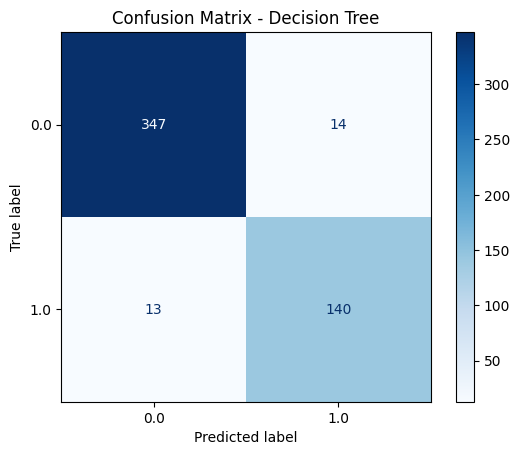

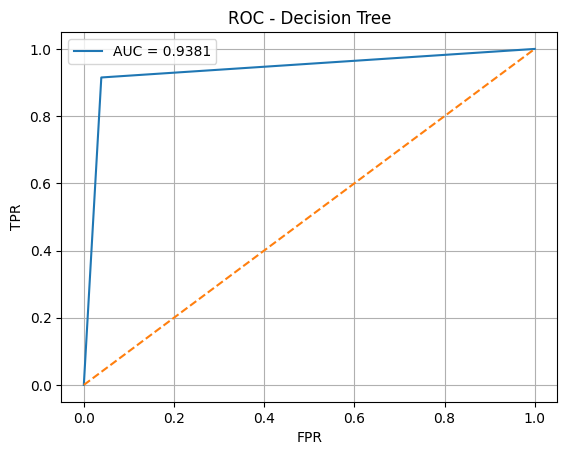

In [23]:

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Decision Tree - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
#plt.xticks(np.linspace(0, 1, 11))
#plt.yticks(np.linspace(0, 1, 11))
plt.title("ROC - Decision Tree")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


# Logistic Regression

Logistic Regression - Classification Report
              precision    recall  f1-score   support

         0.0     0.8729    0.9889    0.9273       361
         1.0     0.9619    0.6601    0.7829       153

    accuracy                         0.8911       514
   macro avg     0.9174    0.8245    0.8551       514
weighted avg     0.8994    0.8911    0.8843       514



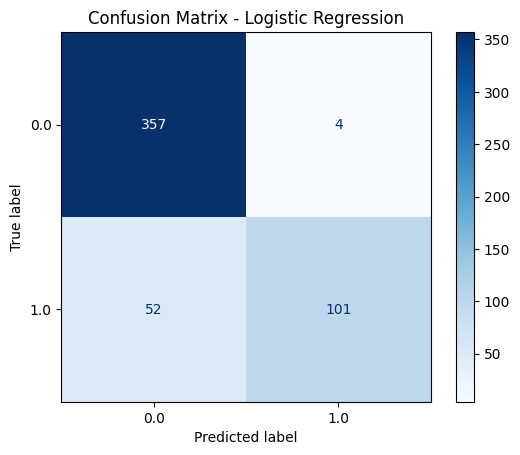

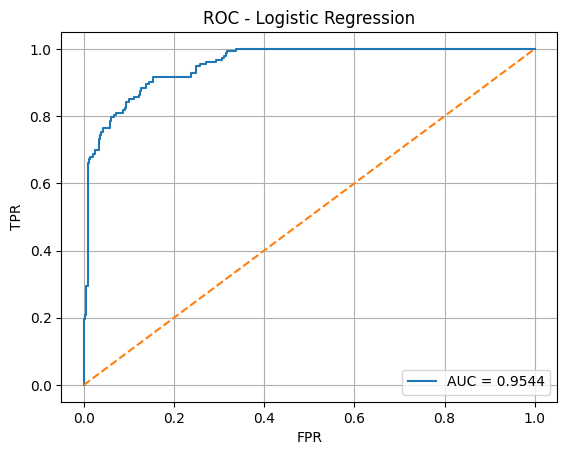

In [24]:

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
#plt.xticks(np.linspace(0, 1, 11))
#plt.yticks(np.linspace(0, 1, 11))
plt.title("ROC - Logistic Regression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


# k-nearest neighbour

KNN - Classification Report
              precision    recall  f1-score   support

         0.0     0.9972    0.9917    0.9944       361
         1.0     0.9806    0.9935    0.9870       153

    accuracy                         0.9922       514
   macro avg     0.9889    0.9926    0.9907       514
weighted avg     0.9923    0.9922    0.9922       514



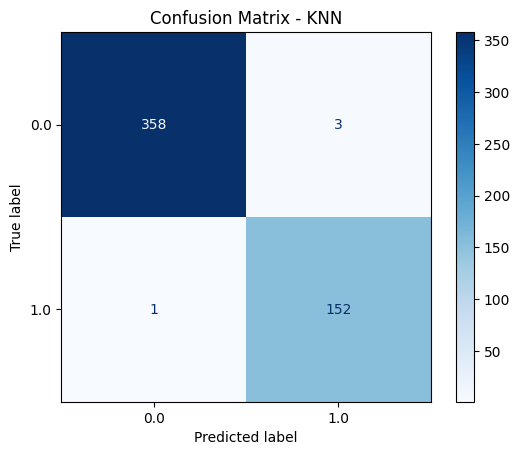

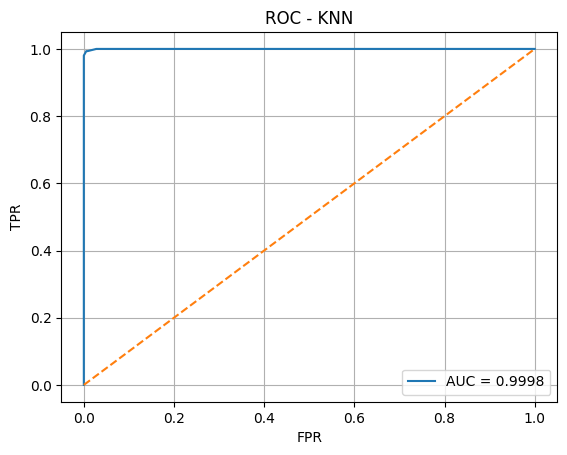

In [25]:

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("KNN - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
#plt.xticks(np.linspace(0, 1, 11))
#plt.yticks(np.linspace(0, 1, 11))
plt.title("ROC - KNN")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


# Linear Discriminant Analysis

LDA - Classification Report
              precision    recall  f1-score   support

         0.0     0.8341    0.9889    0.9049       361
         1.0     0.9535    0.5359    0.6862       153

    accuracy                         0.8541       514
   macro avg     0.8938    0.7624    0.7956       514
weighted avg     0.8696    0.8541    0.8398       514



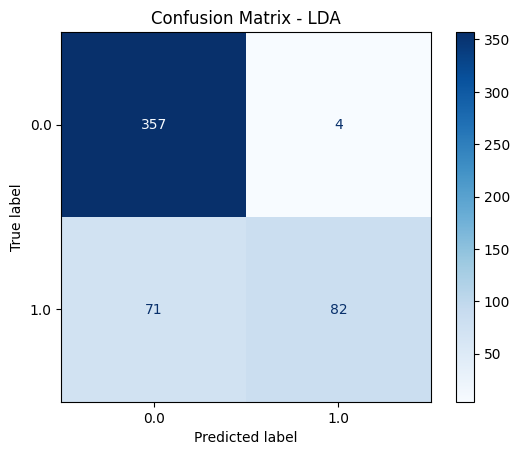

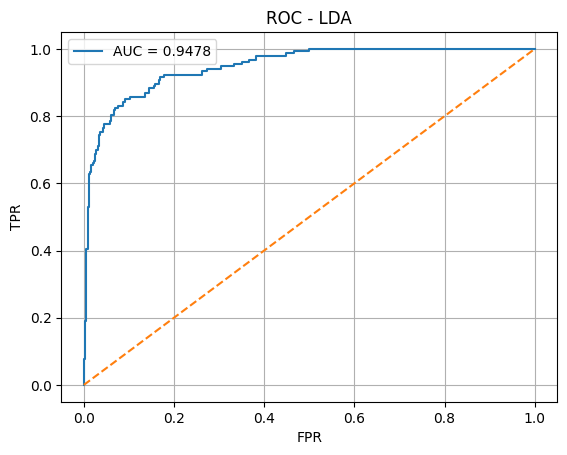

In [26]:

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("LDA - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - LDA")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
#plt.xticks(np.linspace(0, 1, 11))
#plt.yticks(np.linspace(0, 1, 11))
plt.title("ROC - LDA")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


# Naive Bayes Classifier

Naive Bayes - Classification Report
              precision    recall  f1-score   support

         0.0     0.7516    0.9806    0.8510       361
         1.0     0.8372    0.2353    0.3673       153

    accuracy                         0.7588       514
   macro avg     0.7944    0.6080    0.6092       514
weighted avg     0.7771    0.7588    0.7070       514



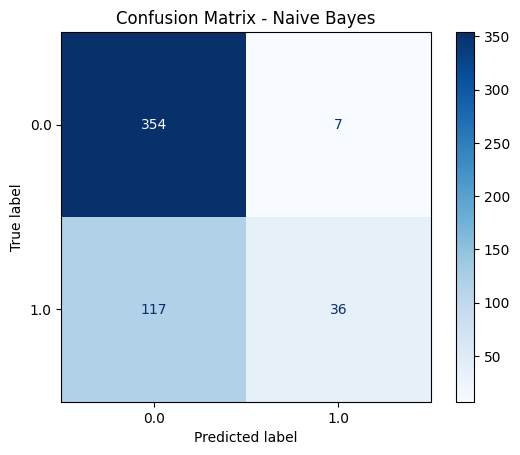

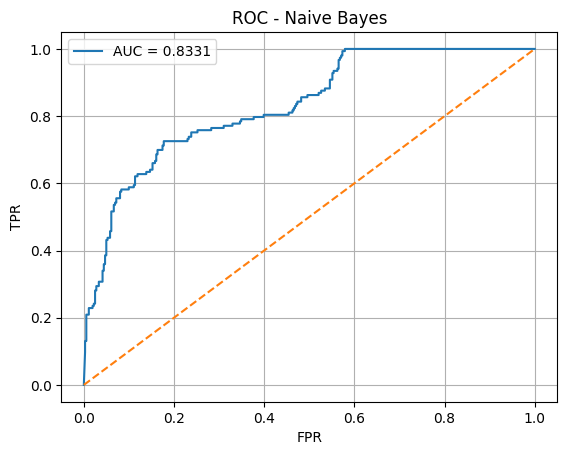

In [27]:

clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Naive Bayes - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
#plt.xticks(np.linspace(0, 1, 11))
#plt.yticks(np.linspace(0, 1, 11))
plt.title("ROC - Naive Bayes")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


# ANN

2025-07-13 07:51:51.094838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752393111.268320    1396 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752393111.318740    1396 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752393116.452413    1396 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/d

Epoch 1/150


I0000 00:00:1752393118.622652    1456 service.cc:148] XLA service 0x7f760400d930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752393118.623058    1456 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752393118.623083    1456 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752393118.823510    1456 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752393119.632336    1456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 - 3s - 82ms/step - accuracy: 0.7018 - loss: 0.6182
Epoch 2/150
33/33 - 0s - 2ms/step - accuracy: 0.7013 - loss: 0.5539
Epoch 3/150
33/33 - 0s - 2ms/step - accuracy: 0.7037 - loss: 0.5066
Epoch 4/150
33/33 - 0s - 2ms/step - accuracy: 0.7325 - loss: 0.4678
Epoch 5/150
33/33 - 0s - 2ms/step - accuracy: 0.7646 - loss: 0.4338
Epoch 6/150
33/33 - 0s - 2ms/step - accuracy: 0.7875 - loss: 0.4048
Epoch 7/150
33/33 - 0s - 2ms/step - accuracy: 0.8124 - loss: 0.3777
Epoch 8/150
33/33 - 0s - 2ms/step - accuracy: 0.8289 - loss: 0.3539
Epoch 9/150
33/33 - 0s - 2ms/step - accuracy: 0.8480 - loss: 0.3331
Epoch 10/150
33/33 - 0s - 2ms/step - accuracy: 0.8748 - loss: 0.3135
Epoch 11/150
33/33 - 0s - 2ms/step - accuracy: 0.8869 - loss: 0.2957
Epoch 12/150
33/33 - 0s - 2ms/step - accuracy: 0.8899 - loss: 0.2801
Epoch 13/150
33/33 - 0s - 2ms/step - accuracy: 0.9011 - loss: 0.2661
Epoch 14/150
33/33 - 0s - 2ms/step - accuracy: 0.9040 - loss: 0.2540
Epoch 15/150
33/33 - 0s - 2ms/step - accuracy: 0.9118 

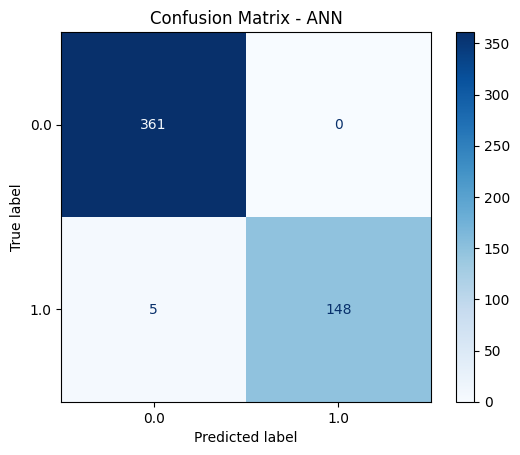

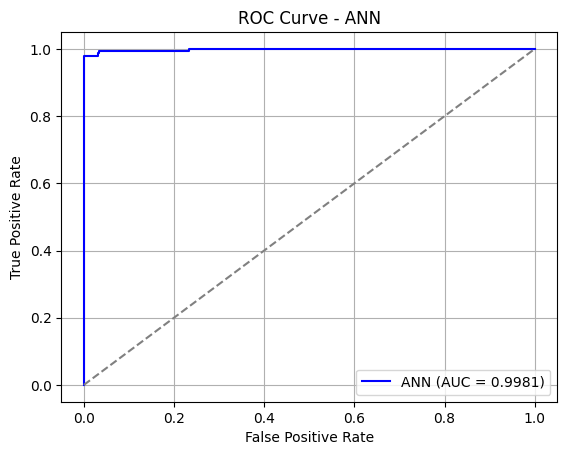

In [28]:

# 1. Separate features and label from df4
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Train-test split (80-20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Build ANN model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 5. Compile with Adagrad optimizer
optimizer = Adagrad(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 6. Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=2)

# 7. Predict on test set
y_test_proba = model.predict(X_test).flatten()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# 8. Evaluation
print("\n" + "="*50)
print("TEST SET EVALUATION (ANN)")
print("="*50)

# A. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Blues')
plt.title("Confusion Matrix - ANN")
plt.show()

# C. ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, label=f'ANN (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ANN')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# *Classification Reports: using SMOTE*

**Train-test split 80:20 and SMOTE applied only on training set**

In [31]:
# Convert 'stress_label' to integer
df4['stress_label'] = df4['stress_label'].astype(int)

In [32]:

# Separate features and target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE on training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print label counts after SMOTE
print("Label distribution after SMOTE on training set:")
print(Counter(y_train_resampled))

# Scale features using StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Label distribution after SMOTE on training set:
Counter({0: 1439, 1: 1439})


# **Decision Tree**

Classification Report:
              precision    recall  f1-score   support

           0     0.9753    0.9834    0.9793       361
           1     0.9600    0.9412    0.9505       153

    accuracy                         0.9708       514
   macro avg     0.9676    0.9623    0.9649       514
weighted avg     0.9707    0.9708    0.9707       514



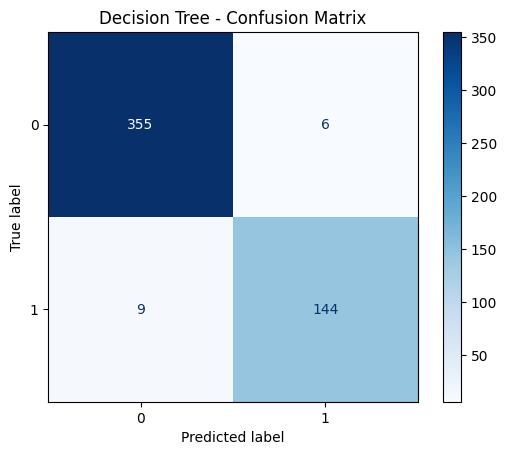

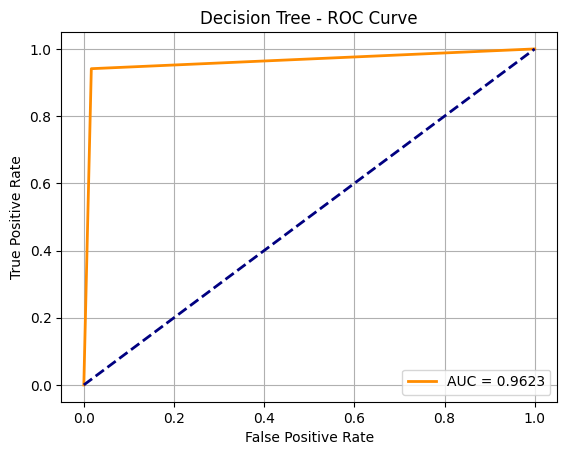

In [33]:


# Step 1: Train Decision Tree on resampled training data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_resampled)

# Step 2: Predict on test set
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for AUC

# Step 3: Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred,digits=4))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# Step 5: AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# LR

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0     0.9259    0.9003    0.9129       361
           1     0.7791    0.8301    0.8038       153

    accuracy                         0.8794       514
   macro avg     0.8525    0.8652    0.8584       514
weighted avg     0.8822    0.8794    0.8804       514



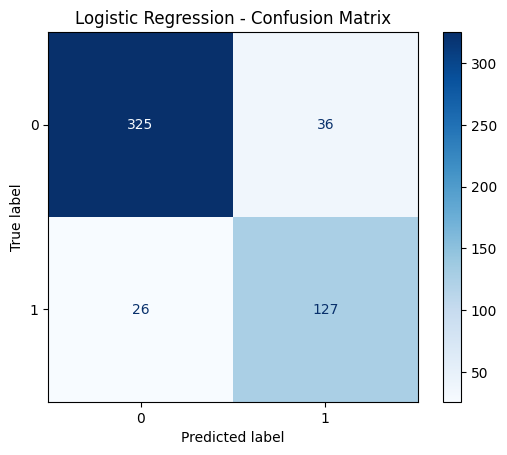

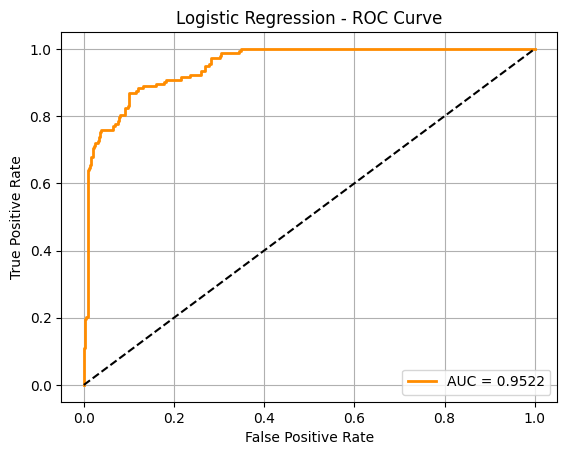

In [34]:

# Train
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train_resampled)

# Predict
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Report
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# K-nearest neighbors

KNN - Classification Report:
              precision    recall  f1-score   support

           0     0.9972    0.9917    0.9944       361
           1     0.9806    0.9935    0.9870       153

    accuracy                         0.9922       514
   macro avg     0.9889    0.9926    0.9907       514
weighted avg     0.9923    0.9922    0.9922       514



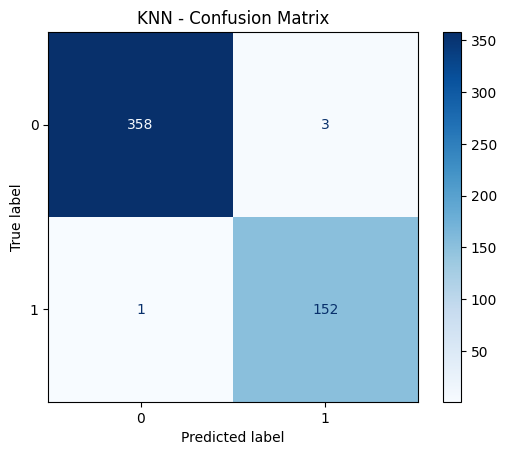

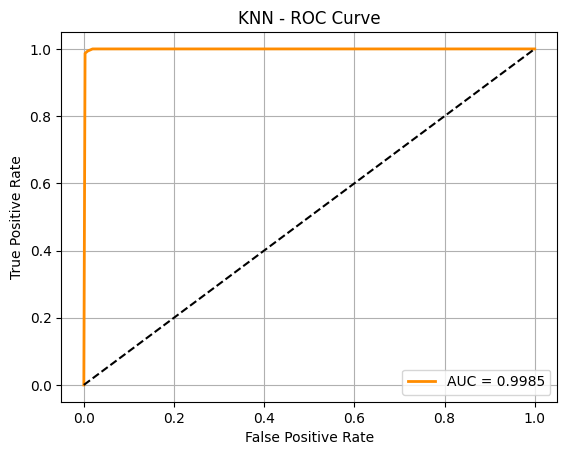

In [35]:

# Train
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train_resampled)

# Predict
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Report
print("KNN - Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("KNN - Confusion Matrix")
plt.show()

# AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# LDA

LDA - Classification Report:
              precision    recall  f1-score   support

           0     0.9073    0.8947    0.9010       361
           1     0.7595    0.7843    0.7717       153

    accuracy                         0.8619       514
   macro avg     0.8334    0.8395    0.8363       514
weighted avg     0.8633    0.8619    0.8625       514



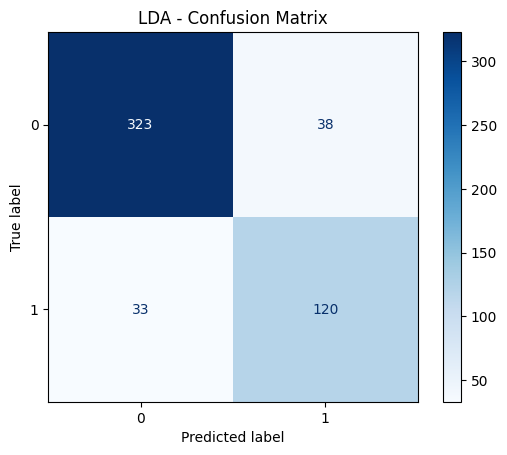

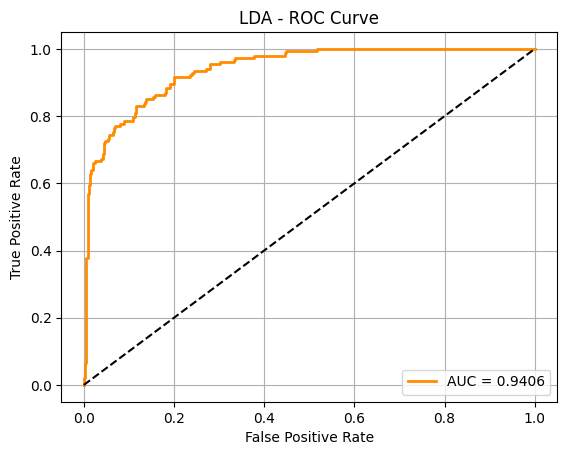

In [36]:

# Train
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train_resampled)

# Predict
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Report
print("LDA - Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("LDA - Confusion Matrix")
plt.show()

# AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# NB

Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0     0.7564    0.9806    0.8540       361
           1     0.8478    0.2549    0.3920       153

    accuracy                         0.7646       514
   macro avg     0.8021    0.6178    0.6230       514
weighted avg     0.7836    0.7646    0.7165       514



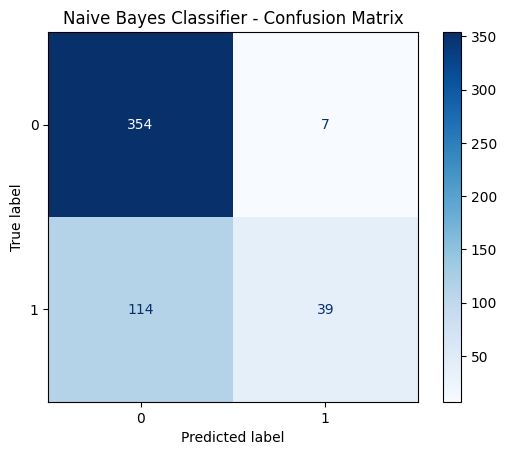

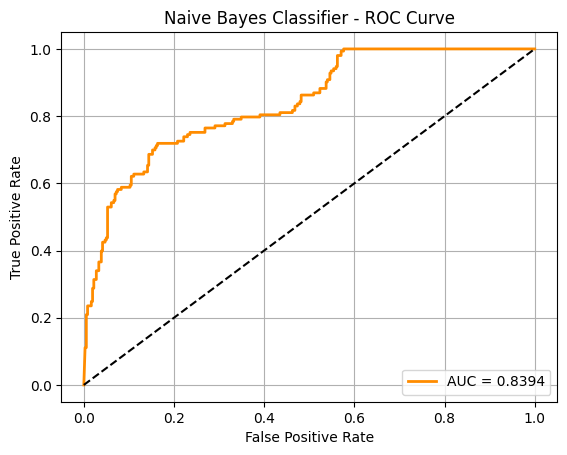

In [37]:

# Train
clf = GaussianNB()
clf.fit(X_train_scaled, y_train_resampled)

# Predict
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Report
print("Naive Bayes - Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Naive Bayes Classifier - Confusion Matrix")
plt.show()

# AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Classifier - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# ann

Epoch 1/150
45/45 - 2s - 50ms/step - accuracy: 0.6220 - loss: 0.6640
Epoch 2/150
45/45 - 0s - 2ms/step - accuracy: 0.7234 - loss: 0.5989
Epoch 3/150
45/45 - 0s - 2ms/step - accuracy: 0.7401 - loss: 0.5400
Epoch 4/150
45/45 - 0s - 2ms/step - accuracy: 0.7561 - loss: 0.4867
Epoch 5/150
45/45 - 0s - 2ms/step - accuracy: 0.7867 - loss: 0.4415
Epoch 6/150
45/45 - 0s - 2ms/step - accuracy: 0.8141 - loss: 0.4006
Epoch 7/150
45/45 - 0s - 2ms/step - accuracy: 0.8645 - loss: 0.3635
Epoch 8/150
45/45 - 0s - 2ms/step - accuracy: 0.8860 - loss: 0.3296
Epoch 9/150
45/45 - 0s - 2ms/step - accuracy: 0.8982 - loss: 0.2996
Epoch 10/150
45/45 - 0s - 2ms/step - accuracy: 0.9079 - loss: 0.2727
Epoch 11/150
45/45 - 0s - 2ms/step - accuracy: 0.9218 - loss: 0.2494
Epoch 12/150
45/45 - 0s - 2ms/step - accuracy: 0.9274 - loss: 0.2292
Epoch 13/150
45/45 - 0s - 2ms/step - accuracy: 0.9343 - loss: 0.2129
Epoch 14/150
45/45 - 0s - 2ms/step - accuracy: 0.9416 - loss: 0.1987
Epoch 15/150
45/45 - 0s - 2ms/step - accur

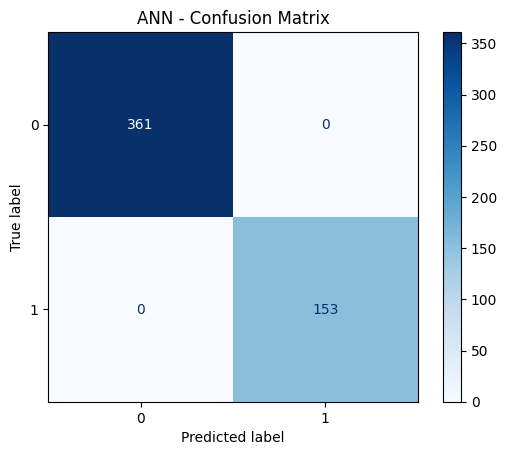

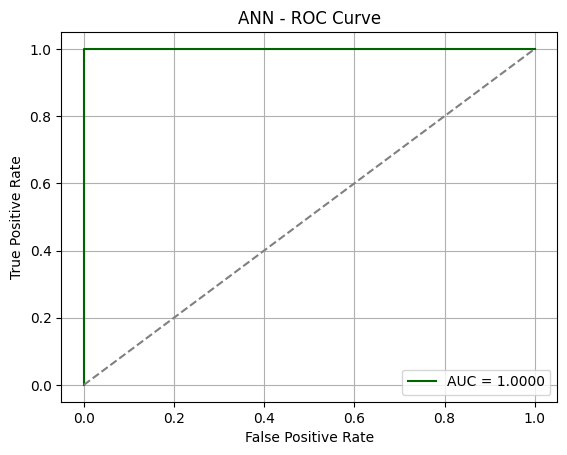

In [38]:

# 1. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 2. Build ANN model (with Input layer to avoid warning)
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 3. Compile
model.compile(optimizer=Adagrad(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 4. Train
model.fit(X_train_scaled, y_train_resampled, epochs=150, batch_size=64, verbose=2)

# 5. Predict
y_test_proba = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# 6. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# 7. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Blues')
plt.title("ANN - Confusion Matrix")
plt.show()

# 8. ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN - ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# *Classification Reports: using HDAO*

In [39]:

# ----- PARAMETERS -----
radius_quantile = 0.00001  # allows for broader synthetic point spread
use_pca = True          # set to False if PCA not needed
pca_variance = 0.99     # how much variance PCA should retain
n_neighbors_lof = 5   # for outlier detection

# ----- FUNCTIONS -----

def compute_local_density(X, k=5):
    """Estimate local density using k-NN average distance."""
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, _ = nbrs.kneighbors(X)
    mean_dist = distances[:, 1:].mean(axis=1)  # exclude self
    density = 1 / (mean_dist + 1e-10)
    return density

def remove_outliers(X, contamination=0.05):
    """Remove outliers using Local Outlier Factor."""
    lof = LocalOutlierFactor(n_neighbors=n_neighbors_lof, contamination=contamination)
    mask = lof.fit_predict(X) == 1  # keep only inliers
    return X[mask]

def generate_gaussian_samples(mean, cov, n_points):
    """Generate synthetic samples from a multivariate Gaussian."""
    dim = mean.shape[0]
    cov += 1e-6 * np.eye(dim)  # regularization to avoid singular matrix
    return np.random.multivariate_normal(mean, cov, size=n_points)

# ----- MAIN HDAO PROCEDURE -----

def improved_HDAO(df_new):
    new_samples_list = []
    df_new['stress_label'] = df_new['stress_label'].astype(int)
    actual_label_counts = df_new['stress_label'].value_counts()
    max_count = actual_label_counts.max()

    for label in actual_label_counts.index:
        print(f"Processing class {label}")
        class_data = df_new[df_new['stress_label'] == label].iloc[:, :-1].values
        n_samples = class_data.shape[0]

        # Step 1: Outlier Removal
        class_data = remove_outliers(class_data, contamination=0.05)
        if class_data.shape[0] < 10:
            print(f"Warning: Too few inliers in class {label}, skipping")
            continue

        # Step 2: PCA (optional)
        if use_pca:
            pca = PCA(n_components=pca_variance)
            class_data_pca = pca.fit_transform(class_data)
        else:
            class_data_pca = class_data

        # Step 3: Density-weighted centroid
        density_weights = compute_local_density(class_data_pca, k=5)
        weighted_sum = np.sum(density_weights[:, None] * class_data_pca, axis=0)
        cDWC = weighted_sum / np.sum(density_weights)

        # Step 4: Radius from centroid
        distances = np.linalg.norm(class_data_pca - cDWC, axis=1)
        radius = np.quantile(distances, radius_quantile)

        # Step 5: Class covariance (in PCA space or original)
        cov_matrix = np.atleast_2d(np.cov(class_data_pca.T))

        # Step 6: Number of synthetic points to generate
        n_generate = max_count - n_samples
        if n_generate > 0:
            synthetic_points = generate_gaussian_samples(cDWC, cov_matrix, n_generate)

            if use_pca:
                synthetic_points = pca.inverse_transform(synthetic_points)

            synthetic_df = pd.DataFrame(synthetic_points, columns=df_new.columns[:-1])
            synthetic_df['stress_label'] = label
            new_samples_list.append(synthetic_df)

    # Combine original + synthetic
    df_augmented = pd.concat([df_new] + new_samples_list, ignore_index=True)

    # Class balance check
    final_label_counts = df_augmented['stress_label'].value_counts().sort_index()
    print("\nFinal Class Counts:\n", final_label_counts)
    print("New dataset shape:", df_augmented.shape)

    return df_augmented


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Combine X_train and y_train before HDAO
train_df = X_train.copy()
train_df['stress_label'] = y_train.values

# Apply HDAO
df_train_hdao = improved_HDAO(train_df)

# Split again after HDAO
X_train_resampled = df_train_hdao.drop('stress_label', axis=1)
y_train_resampled = df_train_hdao['stress_label']

# Scale features using StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Processing class 0
Processing class 1

Final Class Counts:
 stress_label
0    1439
1    1439
Name: count, dtype: int64
New dataset shape: (2878, 21)


# decision Tree

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0     0.9832    0.9723    0.9777       361
           1     0.9363    0.9608    0.9484       153

    accuracy                         0.9689       514
   macro avg     0.9597    0.9665    0.9631       514
weighted avg     0.9692    0.9689    0.9690       514



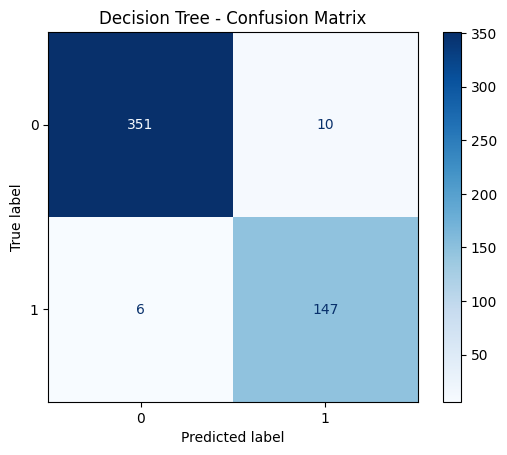

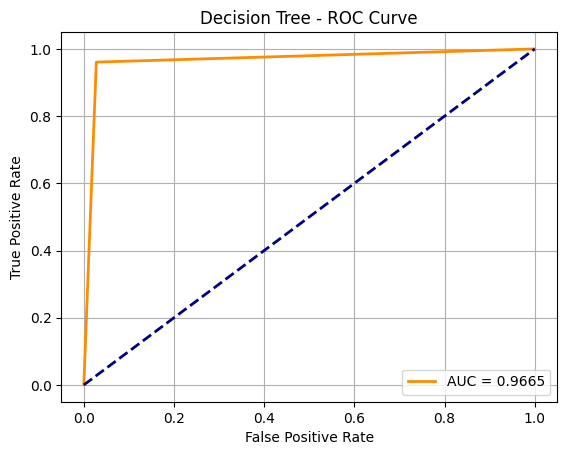

In [41]:


# Step 1: Train Decision Tree on resampled training data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_resampled)

# Step 2: Predict on test set
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for AUC

# Step 3: Classification report
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred,digits=4))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# Step 5: AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# logistics Regression

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0     0.8895    0.9584    0.9227       361
           1     0.8800    0.7190    0.7914       153

    accuracy                         0.8872       514
   macro avg     0.8847    0.8387    0.8570       514
weighted avg     0.8866    0.8872    0.8836       514



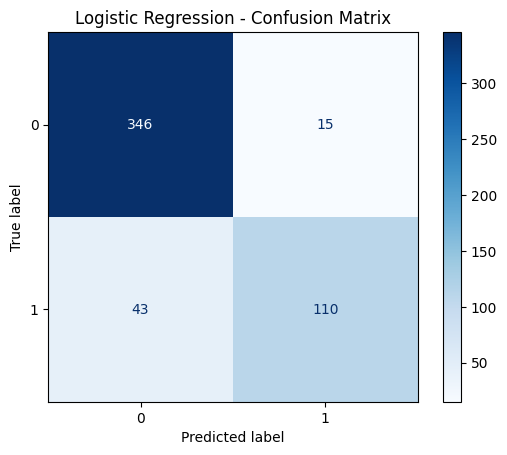

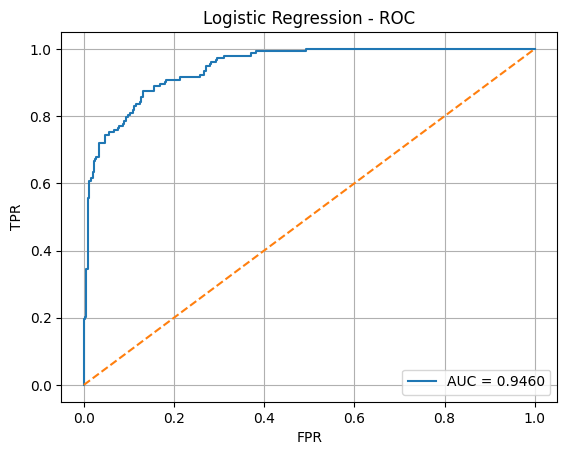

In [42]:


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(X_train_scaled, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Logistic Regression - ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# k-nearest Neighbors

KNN - Classification Report
              precision    recall  f1-score   support

           0     0.9972    0.9945    0.9958       361
           1     0.9870    0.9935    0.9902       153

    accuracy                         0.9942       514
   macro avg     0.9921    0.9940    0.9930       514
weighted avg     0.9942    0.9942    0.9942       514



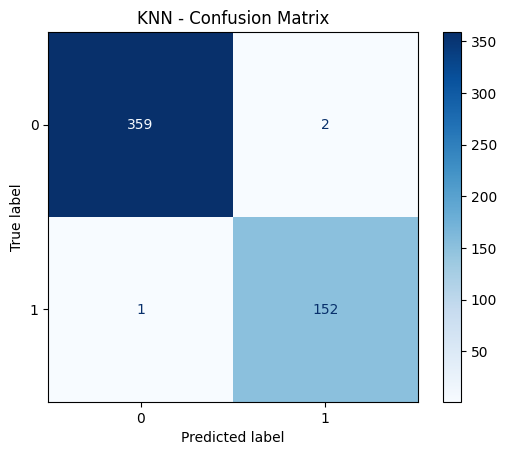

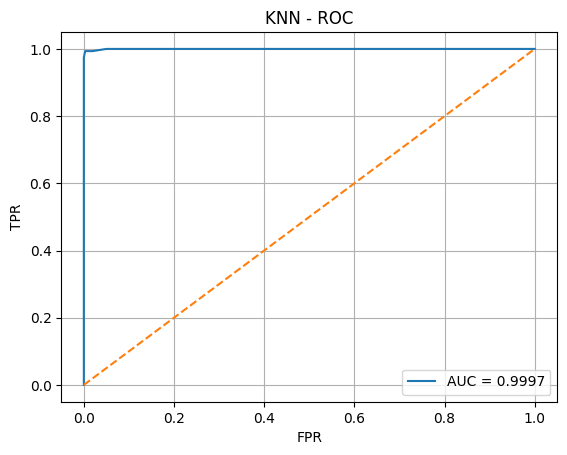

In [43]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train KNN
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train_resampled)

# Predict
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("KNN - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("KNN - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title("KNN - ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


# linear discriminant analysis

LDA - Classification Report
              precision    recall  f1-score   support

           0     0.8759    0.9584    0.9153       361
           1     0.8739    0.6797    0.7647       153

    accuracy                         0.8755       514
   macro avg     0.8749    0.8191    0.8400       514
weighted avg     0.8754    0.8755    0.8705       514



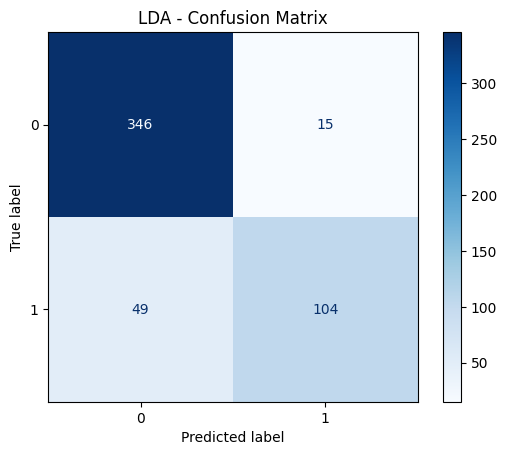

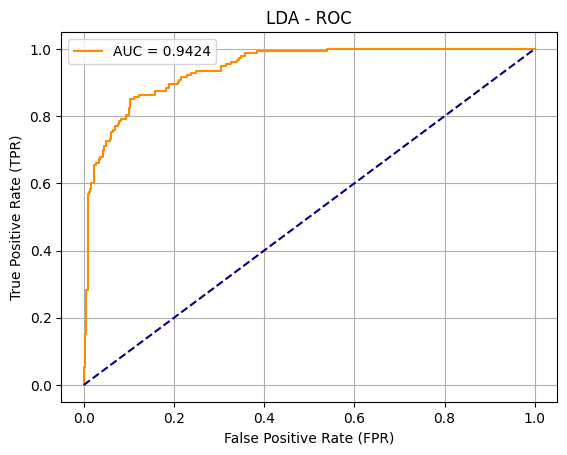

In [44]:

# Step 1: Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 2: Fit LDA
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train_resampled)

# Step 3: Predict
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Step 4: Classification report
print("LDA - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

# Step 5: Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("LDA - Confusion Matrix")
plt.show()

# Step 6: ROC Curve (with higher resolution)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
#plt.xticks(np.linspace(0, 1, 11))
#plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("LDA - ROC")
plt.legend()
plt.grid()
plt.show()


# naive bayes classifier

Naive Bayes - Classification Report
              precision    recall  f1-score   support

           0     0.7666    0.9917    0.8647       361
           1     0.9362    0.2876    0.4400       153

    accuracy                         0.7821       514
   macro avg     0.8514    0.6396    0.6524       514
weighted avg     0.8171    0.7821    0.7383       514



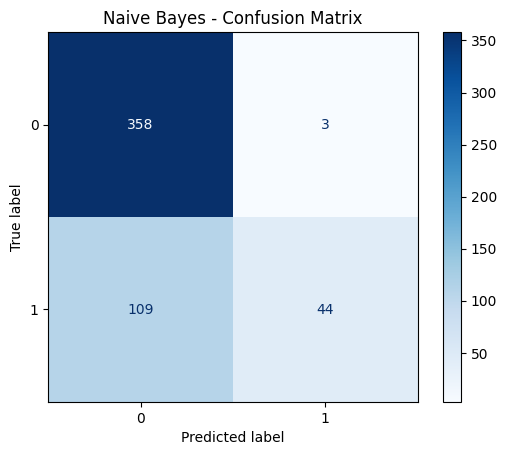

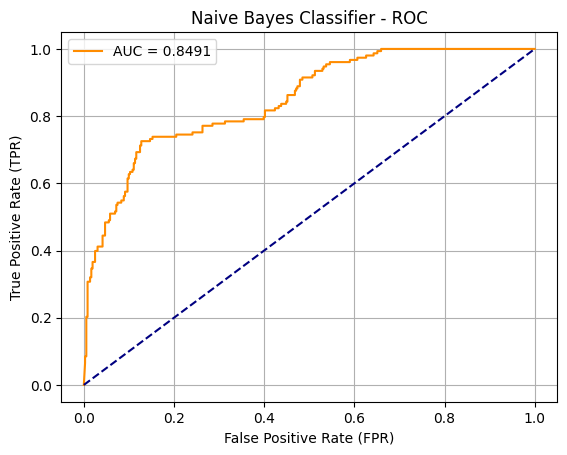

In [45]:

# Step 1: Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train Gaussian Naive Bayes
clf = GaussianNB()
clf.fit(X_train_scaled, y_train_resampled)

# Step 3: Predict on test set
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Step 4: Classification report
print("Naive Bayes - Classification Report")
print(classification_report(y_test, y_pred, digits=4))

# Step 5: Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

# Step 6: ROC Curve (with high resolution)
fpr, tpr, _ = roc_curve(y_test, y_proba)
#plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Naive Bayes Classifier - ROC")
plt.legend()
plt.grid()
plt.show()


# Ann

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 - 2s - 47ms/step - accuracy: 0.7835 - loss: 0.6136
Epoch 2/150
45/45 - 0s - 2ms/step - accuracy: 0.8235 - loss: 0.5090
Epoch 3/150
45/45 - 0s - 2ms/step - accuracy: 0.8391 - loss: 0.4240
Epoch 4/150
45/45 - 0s - 2ms/step - accuracy: 0.8676 - loss: 0.3579
Epoch 5/150
45/45 - 0s - 2ms/step - accuracy: 0.8899 - loss: 0.3053
Epoch 6/150
45/45 - 0s - 2ms/step - accuracy: 0.9104 - loss: 0.2645
Epoch 7/150
45/45 - 0s - 2ms/step - accuracy: 0.9180 - loss: 0.2339
Epoch 8/150
45/45 - 0s - 2ms/step - accuracy: 0.9305 - loss: 0.2116
Epoch 9/150
45/45 - 0s - 2ms/step - accuracy: 0.9382 - loss: 0.1948
Epoch 10/150
45/45 - 0s - 2ms/step - accuracy: 0.9420 - loss: 0.1817
Epoch 11/150
45/45 - 0s - 2ms/step - accuracy: 0.9441 - loss: 0.1711
Epoch 12/150
45/45 - 0s - 2ms/step - accuracy: 0.9468 - loss: 0.1625
Epoch 13/150
45/45 - 0s - 2ms/step - accuracy: 0.9496 - loss: 0.1547
Epoch 14/150
45/45 - 0s - 2ms/step - accuracy: 0.9503 - loss: 0.1480
Epoch 15/150
45/45 - 0s - 2ms/step - accuracy: 0.9517 

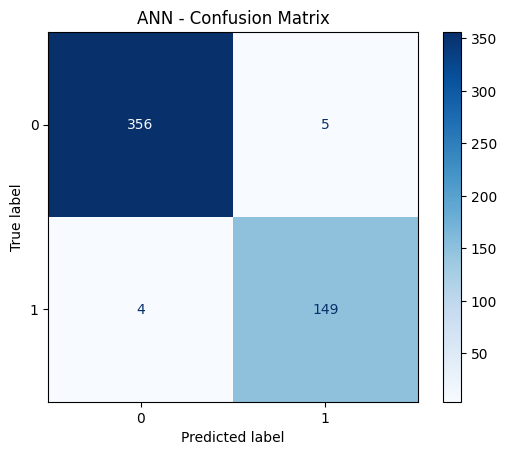

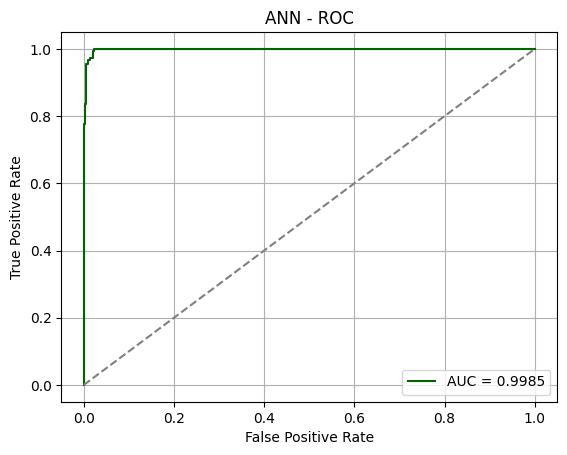

In [46]:

# 1. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 2. Build ANN model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 3. Compile
model.compile(optimizer=Adagrad(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 4. Train
model.fit(X_train_scaled, y_train_resampled, epochs=150, batch_size=64, verbose=2)

# 5. Predict
y_test_proba = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# 6. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# 7. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Blues')
plt.title("ANN - Confusion Matrix")
plt.show()

# 8. ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN - ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Custom Ensemble Model

In [47]:
X_train_resampled.shape

(2878, 20)

Processing class 0
Processing class 1

Final Class Counts:
 stress_label
0    1439
1    1439
Name: count, dtype: int64
New dataset shape: (2878, 21)

Classification Report - Stacked Model with XGBoost Meta-Learner
              precision    recall  f1-score   support

           0     0.9972    0.9972    0.9972       361
           1     0.9935    0.9935    0.9935       153

    accuracy                         0.9961       514
   macro avg     0.9953    0.9953    0.9953       514
weighted avg     0.9961    0.9961    0.9961       514



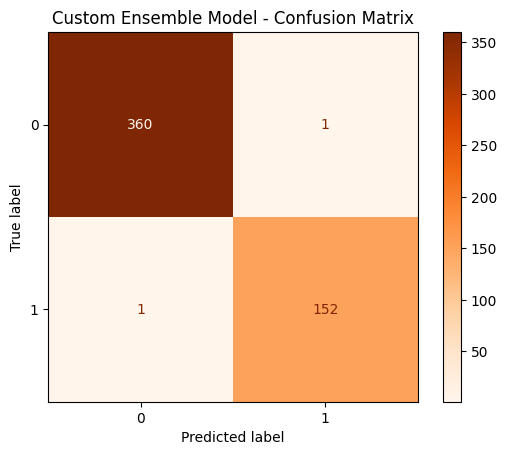

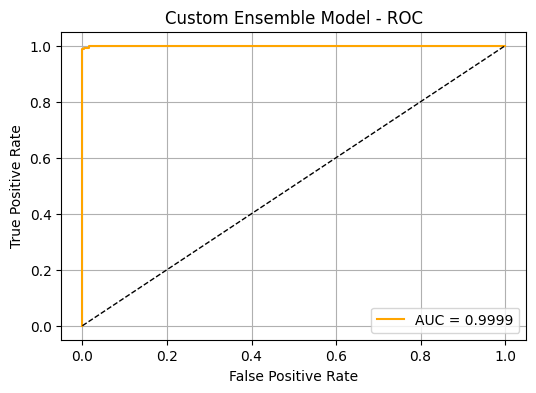

In [48]:


# Step 1: Prepare features and target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2.5: Apply HDAO
train_df = X_train.copy()
train_df['stress_label'] = y_train.values
df_train_hdao = improved_HDAO(train_df)
X_train_resampled = df_train_hdao.drop('stress_label', axis=1)
y_train_resampled = df_train_hdao['stress_label']

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define base learners with scaling
base_learners = [
    ('lda', Pipeline([
        ('scaler', StandardScaler()),
        ('lda', LinearDiscriminantAnalysis())
    ])),
    ('knn', Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])),
    ('lr', Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=100))
    ]))
]


# Step 4: Define XGBoost as final estimator (tree-based, no scaling needed)
meta_learner = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,   # for older versions of xgboost compatibility
    eval_metric='logloss',     # binary classification loss
    random_state=42
)


# Step 5: Create stacking classifier
boosted_stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=False
)

# Step 6: Train the model using resampled and scaled data
boosted_stack.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluation
y_pred = boosted_stack.predict(X_test)
print("\n" + "="*60)
print("Classification Report - Stacked Model with XGBoost Meta-Learner")
print("="*60)
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Custom Ensemble Model - Confusion Matrix")
plt.show()

# ROC-AUC Curve
y_proba = boosted_stack.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="orange")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Custom Ensemble Model - ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Lightweight estimations

In [49]:

# Step 1: Save the trained stacking model
joblib.dump(boosted_stack, "boosted_stack_model.pkl")
model_size_bytes = os.path.getsize("boosted_stack_model.pkl")
model_size_mb = model_size_bytes / (1024 ** 2)

# Step 2: Inference Time (on a single test sample with feature names)
x_sample = X_test.iloc[[0]]  # preserves column names for pipelines
start_time = time.time()
_ = boosted_stack.predict(x_sample)
end_time = time.time()
inference_time_ms = (end_time - start_time) * 1000

# Step 3: Parameter Count (approximation for base + meta learners)
d = X_train_scaled.shape[1]   # number of input features
c = len(np.unique(y_train_resampled))  # number of output classes
n = len(X_train_resampled)  # number of training samples

params_lda = d * (c - 1)
params_knn = 0  # instance-based, no learnable params
params_lr = d + 1  # weights + bias
params_xgb = 100 * (2**3 - 1)  # 100 trees with depth=3 (7 nodes/tree)

param_total = params_lda + params_knn + params_lr + params_xgb

# Step 4: Approximate RAM usage (roughly 2x model size during execution)
ram_usage_mb = model_size_mb * 2

# Step 5: FLOPs estimation (basic approximation per model type)
flops_lda = 2 * d
flops_knn = d * n
flops_lr = 2 * d
flops_xgb = 100 * 3  # ~3 ops per depth in XGBoost
flops_total = flops_lda + flops_knn + flops_lr + flops_xgb
flops_million = flops_total / 1e6

# Step 6: Model Load Time
start_load = time.time()
_ = joblib.load("boosted_stack_model.pkl")
end_load = time.time()
load_time_ms = (end_load - start_load) * 1000

# Step 7: Print Results
print("\n--- Lightweight Evaluation Metrics ---")
print(f"1. Model Size           : {model_size_mb:.2f} MB")
print(f"2. Inference Time       : {inference_time_ms:.2f} ms")
print(f"3. Parameter Count      : {param_total}")
print(f"4. RAM Usage (Est.)     : {ram_usage_mb:.2f} MB")
print(f"5. FLOPs (Approximate)  : {flops_million:.2f} Million")
print(f"6. Model Load Time      : {load_time_ms:.2f} ms")



--- Lightweight Evaluation Metrics ---
1. Model Size           : 0.57 MB
2. Inference Time       : 7.21 ms
3. Parameter Count      : 741
4. RAM Usage (Est.)     : 1.15 MB
5. FLOPs (Approximate)  : 0.06 Million
6. Model Load Time      : 5.61 ms


# XAI

  0%|          | 0/100 [00:00<?, ?it/s]

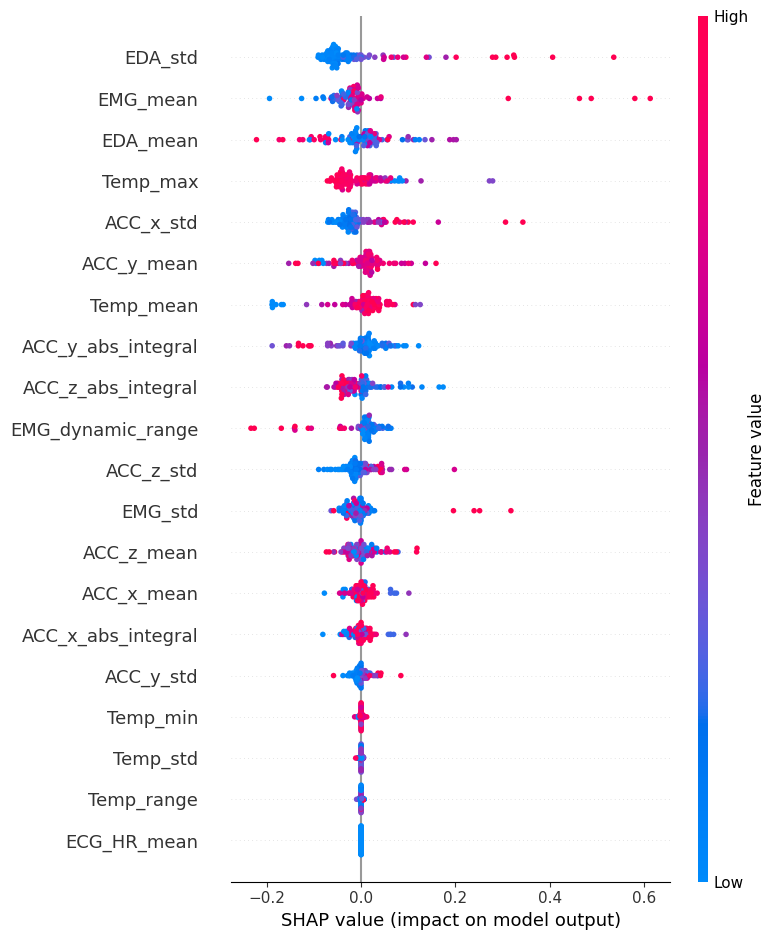

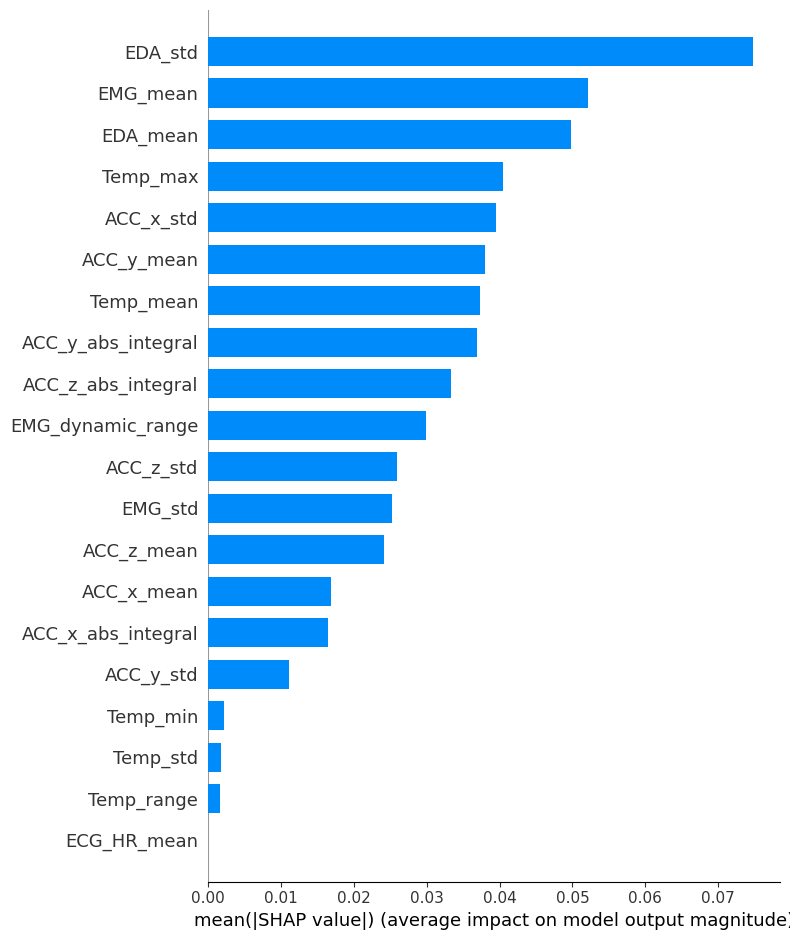

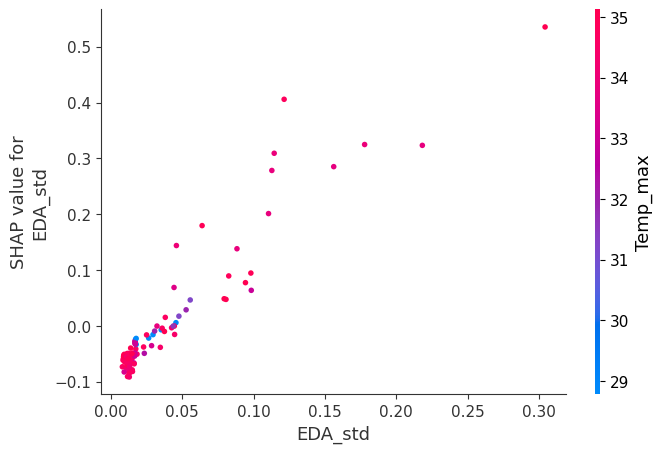

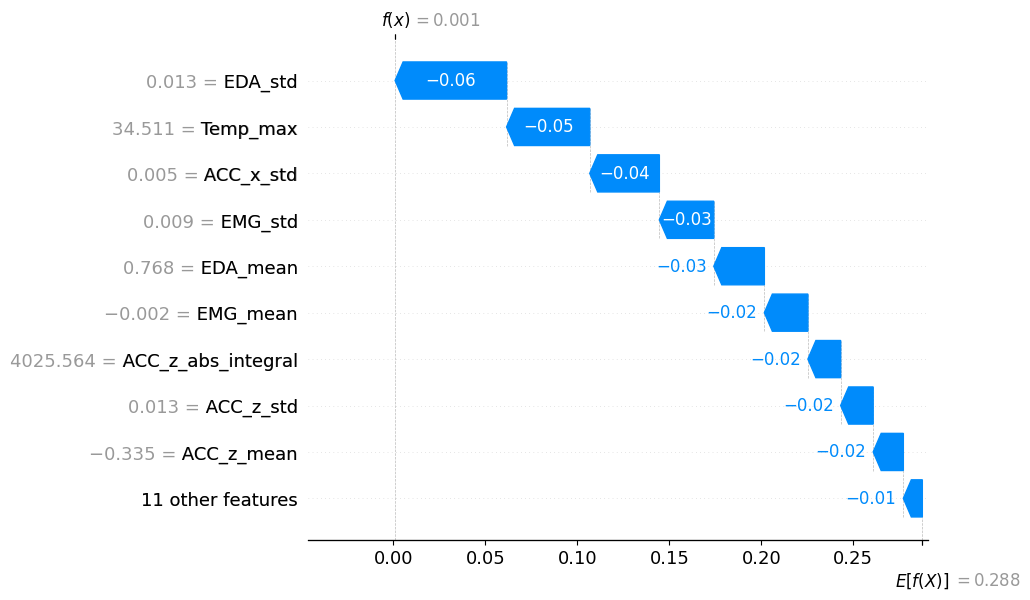

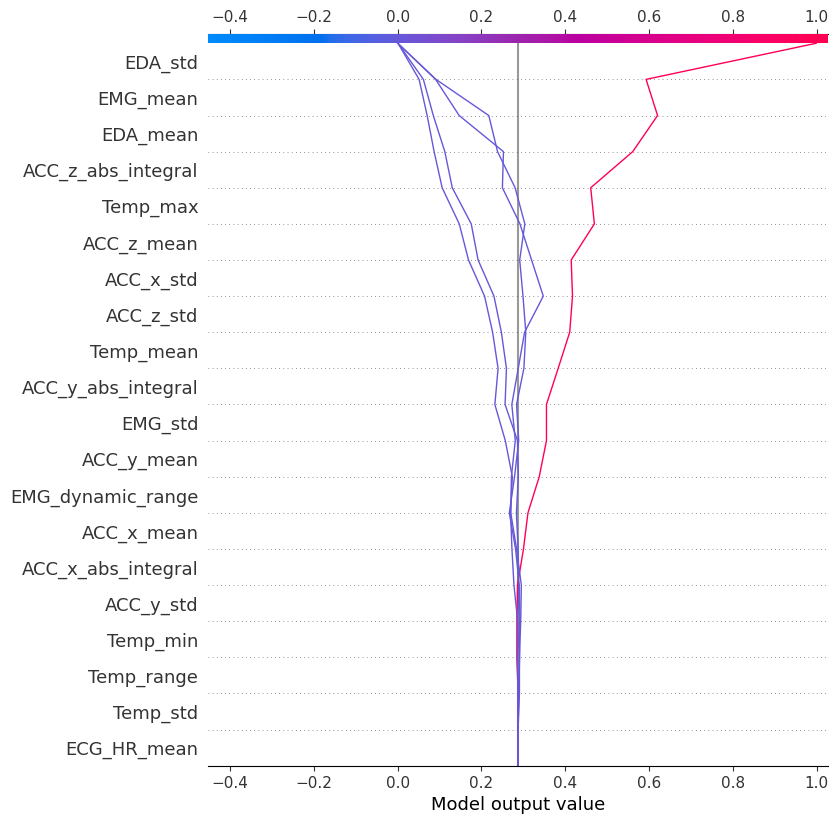

In [50]:

# Sample 100 rows from X_test (keep as DataFrame to retain feature names)
X_sample = X_test.sample(n=100, random_state=42)

# Define prediction function (takes pandas DataFrame)
predict_fn = lambda x: boosted_stack.predict_proba(pd.DataFrame(x, columns=X_test.columns))[:, 1]

# Initialize KernelExplainer with DataFrame
explainer = shap.KernelExplainer(predict_fn, X_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 1. Beeswarm summary plot
shap.summary_plot(shap_values, X_sample)

# 2. Bar plot summary
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# 3. Dependence plot for top feature
top_feature = X_sample.columns[np.abs(shap_values).mean(0).argmax()]
shap.dependence_plot(top_feature, shap_values, X_sample)

# 4. Force plot for a single sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0])

# 5. Waterfall plot for one instance
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_sample.iloc[0],
    feature_names=X_sample.columns
))

# 6. Decision plot
shap.decision_plot(explainer.expected_value, shap_values[:5], X_sample.iloc[:5])
